In [1]:
# import sys 
# sys.path.append('../')
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision



/home/mahdigilany/offline_codes/codes/TRUSnet


In [2]:
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra
from src.configuration import register_configs
from tqdm import tqdm

register_configs()

GlobalHydra.instance().clear()
initialize(config_path="../configs", version_base="1.1")

dm_config = compose(
    config_name="datamodule/ssl_tuffc.yaml",
    overrides=[
        "datamodule.splits.cohort_specifier=['UVA600']",
        "datamodule.splits.train_val_split_seed=0",
        "datamodule.splits.test_as_val=True",
        "datamodule.patch_view_config.needle_region_only=True",
        "datamodule.patch_view_config.prostate_region_only=False",
        "datamodule._target_='src.lightning.datamodules.exact_datamodule.PatchDataModuleForSemiSupervisedLearningFahimeh'",
        "datamodule.loader_config.num_workers=0",
        "datamodule.loader_config.batch_size=32",

    ]
    )
lightning_data_module = instantiate(dm_config)['datamodule']
# print(lightning_data_module)
lightning_data_module.setup()


Indexing Patches: 100%|██████████| 81/81 [00:02<00:00, 28.16it/s]


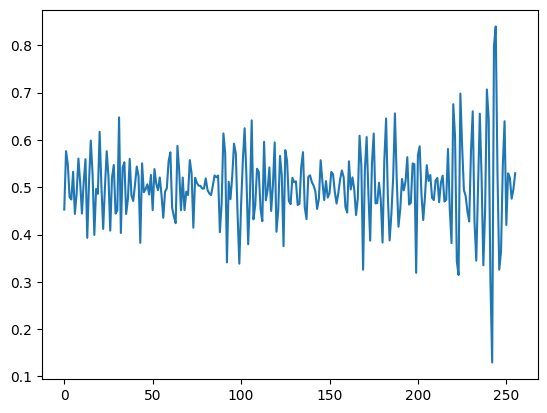

In [12]:
x = lightning_data_module.train_ds[0][0][0][0,:,:]
plt.plot(x[:,0])

In [41]:
from src.lightning.lightning_modules.evaluation_base import EvaluationBase 
from typing import Optional, List
from src.modeling.optimizer_factory import OptimizerConfig
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy
from contextlib import nullcontext

class OneNetDivideMix(EvaluationBase):
    """
    This class implements DivideMix, a semi-supervised learning method for prostate cancer detection.
    """

    def __init__(
        self,
        backbone1: DictConfig,
        checkpoint: Optional[str] = None,
        semi_sup: bool = False,
        batch_size: int = 32,
        epochs: int = 100,
        num_classes: int = 2,
        temperature: float = 0.1,
        beta_alpha: float = 0.75,
        GMM_prob_threshold: float = 0.5,
        GMM_cycle: int = 3,
        opt_cfg: OptimizerConfig = OptimizerConfig(),
    ):

        super().__init__(batch_size, epochs, opt_cfg=opt_cfg)

        self.semi_sup = semi_sup
        self.temperature = temperature
        self.beta_alpha = beta_alpha
        self.num_classes = num_classes
        self.GMM_prob_threshold = GMM_prob_threshold
        self.GMM_cycle = GMM_cycle
        
        # logging.getLogger(__name__).info(
        #     f"Instantiating model {backbone._target_} as backbone for finetuner"
        # )
        finetune1 = instantiate(backbone1)

        # assert isinstance(
        #     backbone, FeatureExtractionProtocol
        # ), "Finetuned model must support feature extraction"
        self.backbone1 = finetune1.backbone

        # self.linear_layer1 = torch.nn.Linear(self.backbone1.features_dim, num_classes)
        # self.linear_layer2 = torch.nn.Linear(self.backbone2.features_dim, num_classes)
        self.linear_layer1 = finetune1.linear_layer

        self._checkpoint_is_loaded = False

        if checkpoint is not None:
            self.load_from_pretraining_ckpt(checkpoint)

        self.train_acc = Accuracy()

        self.inferred_no_centers = 1

        self.train_lossHistory1 = []
        self.val_macroLoss_all_centers = []
        self.test_macroLoss_all_centers = []

        self.save_hyperparameters()

    def load_from_pretraining_ckpt(self, ckpt: str):
        if isinstance(self.backbone1, LightningModule):
            self.backbone1.load_from_checkpoint(ckpt)

        self._checkpoint_is_loaded = True

    @property
    def learnable_parameters(self) -> List[dict]:
        """Adds projector parameters to the parent's learnable parameters.

        Returns:
            List[dict]: list of learnable parameters.
        """
        parameters = [
            {"name": "linear_layer1",  "params": self.linear_layer1.parameters()},
        ]
        if self.semi_sup:
            parameters.append(
                {"name": "backbone1", "params": self.backbone1.parameters()}
            )

        return parameters

    def co_divide_GMM(self, net1: nn.Module, dataloader: data.DataLoader):
        """implements divide mix GMM algorithm using two networks and a dataset"""
        
        
        from sklearn.mixture import GaussianMixture
        net1.eval()

        losses1 = []
        with torch.no_grad():
            for batch_idx, batch in tqdm(enumerate(dataloader), desc="GMM on training sets", total=len(dataloader)):
                # if batch_idx == 5:
                #     break
                
                (X1, X2) , pos, y, metadata = batch
                X1 = X1.to(self.device)
                # X2 = X2.to(self.device)
                y = y.to(self.device)

                # todo augmented data is passed to the network
                logits1, _ = self._forward(X1)
                
                loss1 = F.cross_entropy(logits1, y, reduction='none')
                losses1.append(loss1.detach())
        
        losses1 = torch.cat(losses1).reshape(-1,1).cpu().numpy()
        losses1 = (losses1 - losses1.min())/(losses1.max() - losses1.min())
        
        self.train_lossHistory1.append(losses1)
                
        if len(self.train_lossHistory1) > 5:
            self.train_lossHistory1 = self.train_lossHistory1[-5:]
            self.train_lossHistory2 = self.train_lossHistory2[-5:]
            input_loss1 = np.concatenate(self.train_lossHistory1[-5:], axis=0).reshape(-1,1)
        else:
            input_loss1 = np.concatenate(self.train_lossHistory1, axis=0).reshape(-1,1)
        
    
        GMM1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    
        GMM1.fit(input_loss1)
        
        prob1 = GMM1.predict_proba(input_loss1) 
        prob1 = prob1[:,GMM1.means_.argmin()] 
        # prob1 = torch.tensor(prob1, device=self.device).view(-1,1)
        
        labeled_train_idx1 = np.where(prob1 > self.GMM_prob_threshold)[0]
        unlabeled_train_idx1 = np.where(prob1 <= self.GMM_prob_threshold)[0] 
        
        # permute labeled_train_idx1
        labeled_train_idx1 = np.random.permutation(labeled_train_idx1)
        unlabeled_train_idx1 = np.random.permutation(unlabeled_train_idx1)
        
        prob1 = torch.tensor(prob1, device=self.device).view(-1,1)
        return labeled_train_idx1, unlabeled_train_idx1, prob1
    
    def on_train_epoch_start(self) -> None:
        """
        Changing model to eval() mode has to happen at the start of every epoch,
        and should only happen if we are not in semi-supervised mode
        """
        if not self.semi_sup:
            self.backbone1.eval()
        
        # every n epochs, co-divide the dataset to labeled and unlabeled sets
        # if self.trainer.current_epoch%self.GMM_cycle == 0:
        if self.currentepoch%self.GMM_cycle == 0:
            # self.trainer.datamodule.labeled_train_idx, self.trainer.datamodule.ulabeled_train_idx,\
            self.datamod_.labeled_train_idx1, self.datamod_.unlabeled_train_idx1,\
            self.GMM_labeled_probs1 = self.co_divide_GMM(
                    nn.ModuleList([self.backbone1, self.linear_layer1]),
                    # self.trainer.datamodule.train_GMM_loader
                    self.datamod_.train_GMM_loader
                )

    def shared_step(self, batch):
        x, pos, y, metadata = batch

        with nullcontext() if self.semi_sup else torch.no_grad():
            feats1, feats2 = self.get_feats(x)

        feats1 = feats1.view(feats1.size(0), -1)
        feats2 = feats2.view(feats2.size(0), -1)
        
        logits1 = self.linear_layer1(feats1)
        logits2 = self.linear_layer1(feats2)
        
        loss1 = F.cross_entropy(logits1, y)
        loss2 = F.cross_entropy(logits2, y)

        return (loss1, loss2), (logits1,logits2), y, metadata

    def get_feats(self, x):
        return self.backbone1.get_features(x)

    def _forward(self, x):
        with nullcontext() if self.semi_sup else torch.no_grad():
            feats1 = self.get_feats(x)
            feats1 = feats1.view(feats1.size(0), -1)
            
        logits1 = self.linear_layer1(feats1)
        return logits1, feats1
        
    def training_step(self, batch, batch_idx):
        if self.semi_sup:
            self.backbone1.train()
        self.linear_layer1.train()
        
        labeled_batch = batch["labeled"]
        unlabeled_batch = batch["unlabeled"]
        
        (X1, X2), pos, labeled_labels, metadata = labeled_batch
        (X1_unlabeled, X2_unlabeled), pos, unlabeled_labels, metadata = unlabeled_batch
        batch_size = X1.size(0)
        
        # todo remove after adding the code to the pipeline
        X1, X2, X1_unlabeled, X2_unlabeled = X1.to(self.device), X2.to(self.device), X1_unlabeled.to(self.device), X2_unlabeled.to(self.device)
        labeled_labels = labeled_labels.to(self.device)
        labeled_labels = F.one_hot(labeled_labels, num_classes=self.num_classes).float()
        
        start_indx = batch_idx*batch_size
        end_indx = (batch_idx+1)*batch_size
        w_x = self.GMM_labeled_probs1[start_indx:end_indx].view(-1,1)


        with torch.no_grad():
            # get unlablled data pseudo labels
            logits1_unlabeled_model1, _ = self._forward(X1_unlabeled)
            logits2_unlabeled_model1, _ = self._forward(X2_unlabeled)
        
            unlabeled_avg_probs = (torch.softmax(logits1_unlabeled_model1, dim=1) + 
                                    torch.softmax(logits2_unlabeled_model1, dim=1)) / 2
            unlabeled_pseudo_targets = unlabeled_avg_probs**(1/self.temperature)
            unlabeled_pseudo_targets = unlabeled_pseudo_targets / unlabeled_pseudo_targets.sum(dim=1, keepdim=True) # normalize
            unlabeled_pseudo_targets = unlabeled_pseudo_targets.detach()    
        
            # get lablled data pseudo labels
            logits1_labeled_model1, _ = self._forward(X1)
            logits2_labeled_model1, _ = self._forward(X2)
        
        

        labeled_avg_probs = (torch.softmax(logits1_labeled_model1, dim=1) + 
                                 torch.softmax(logits2_labeled_model1, dim=1)) / 2
        # finding labels for labeled data using GMM1
        labeled_avg_probs1 = w_x*labeled_labels + (1-w_x)*labeled_avg_probs              
        labeled_pseudo_targets1 = labeled_avg_probs1**(1/self.temperature) # temparature sharpening 
        labeled_pseudo_targets1 = labeled_pseudo_targets1 / labeled_pseudo_targets1.sum(dim=1, keepdim=True) # normalize           
        labeled_pseudo_targets1 = labeled_pseudo_targets1.detach()       
        
        
        # mixmatch
        _lambda = np.random.beta(self.beta_alpha, self.beta_alpha)        
        _lambda = max(_lambda, 1-_lambda)
                
        all_inputs = torch.cat([X1, X2, X1_unlabeled, X2_unlabeled], dim=0)
        all_targets1 = torch.cat([labeled_pseudo_targets1, labeled_pseudo_targets1, unlabeled_pseudo_targets, unlabeled_pseudo_targets], dim=0)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a1, target_b1 = all_targets1, all_targets1[idx]
        
        mixed_input = _lambda * input_a + (1 - _lambda) * input_b        
        mixed_target1 = _lambda * target_a1 + (1 - _lambda) * target_b1
                
        
        logits_mixed_model1, _ = self._forward(mixed_input)
        logits_labeled1 = logits_mixed_model1[:batch_size*2]
        logits_unlabeled1 = logits_mixed_model1[batch_size*2:]        
        
        
        loss_labeled1, loss_unlabeled1, lambda_unlabeled1 = self.semi_loss(logits_labeled1, mixed_target1[:batch_size*2], 
                                                                           logits_unlabeled1, mixed_target1[batch_size*2:], 
                                                                           #  self.trainer.current_epoch+batch_idx/self.num_training_steps
                                                                           self.currentepoch+batch_idx/self.num_training_steps
                                                                           )
        
        # regularization
        prior = torch.ones(self.num_classes)/self.num_classes
        prior = prior.to(self.device)      
          
        pred_mean1 = torch.softmax(logits_mixed_model1, dim=1).mean(0)
        penalty1 = torch.sum(prior*torch.log(prior/pred_mean1))

        # loss
        loss = loss_labeled1 + lambda_unlabeled1 * loss_unlabeled1  + penalty1
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx: int):
        loss, logits, y, *metadata = self.shared_step(batch)

        self.logging_combined_centers_loss(dataloader_idx, loss)

        return loss, logits, y, *metadata

    def validation_epoch_end(self, outs):        
        kwargs = {
            "on_step": False,
            "on_epoch": True,
            "sync_dist": True,
            "add_dataloader_idx": False,
        }
        self.log(
            "val/finetune_loss",
            torch.mean(torch.tensor(self.val_macroLoss_all_centers)),
            prog_bar=True,
            **kwargs,
        )
        self.log(
            "test/finetune_loss",
            torch.mean(torch.tensor(self.test_macroLoss_all_centers)),
            prog_bar=True,
            **kwargs,
        )

    def test_step(self, batch, batch_idx):
        loss, logits, y, *metadata = self.shared_step(batch)
        return loss, logits, y, *metadata

    def on_epoch_end(self):
        self.train_acc.reset()

        self.val_macroLoss_all_centers = []
        self.test_macroLoss_all_centers = []
        
    def logging_combined_centers_loss(self, dataloader_idx, loss):
        """macro loss for centers"""
        self.inferred_no_centers = (
            dataloader_idx + 1
            if dataloader_idx + 1 > self.inferred_no_centers
            else self.inferred_no_centers
        )

        if dataloader_idx < self.inferred_no_centers / 2.0:
            self.val_macroLoss_all_centers.append(loss)
        else:
            self.test_macroLoss_all_centers.append(loss)

    def semi_loss(self, outputs_labeled, targets_labeled, outputs_unlabeled, targets_unlabeled, epoch, warm_up=0):
        probs_u = torch.softmax(outputs_unlabeled, dim=1)

        loss_labeled = -torch.mean(torch.sum(F.log_softmax(outputs_labeled, dim=1) * targets_labeled, dim=1))
        loss_unlabeled = torch.mean((probs_u - targets_unlabeled)**2)

        def linear_rampup(current, warm_up=0, rampup_length=16):
            current = np.clip((current-warm_up) / rampup_length, 0.0, 1.0)
            return 25.0*float(current)

        return loss_labeled, loss_unlabeled, linear_rampup(epoch, warm_up)

    @property
    def num_training_steps(self) -> int:
        return len(self.datamod_.train_ds) // self.batch_size

### Dividemix module

In [42]:
model_conf1 = OmegaConf.create({"_target_": "src.modeling.registry.create_model",
                                "_recursive_": False,
                                "model_name": "finetune_linear_all_centers",
                                "seed": 0,
                                "split_seed": 0,
                                })

onenet_dividemix_model = OneNetDivideMix(model_conf1).to('cuda')


/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


In [43]:
# loading adam optimizer
from torch.optim import Adam
optim = Adam(onenet_dividemix_model.learnable_parameters, lr=0.0001, weight_decay=1e-6)

# training dividemix model for 100 epochs
epochs = 2

loss_over_epochs = []
for i in range(epochs):
    train_loss = []
    onenet_dividemix_model.currentepoch = i
    onenet_dividemix_model.datamod_ = lightning_data_module
    # GMM on loss
    onenet_dividemix_model.on_train_epoch_start()
    
    # train first model
    train_loader = lightning_data_module.train_dataloader()
    
    labeled_loader, unlabeled_loader =\
    train_loader["labeled"], train_loader["unlabeled"]
    
    unlabeled_loader_iter = iter(unlabeled_loader)
    for batch_idx, batch_labeled in tqdm(enumerate(labeled_loader), desc="batch", total=len(labeled_loader)):
        try:
            batch_unlabeled = next(unlabeled_loader_iter)
        except:
            unlabeled_loader_iter = iter(unlabeled_loader)
            batch_unlabeled = next(unlabeled_loader_iter)
        loss = onenet_dividemix_model.training_step({"labeled":batch_labeled, 
                                              "unlabeled": batch_unlabeled},
                                              batch_idx)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss.append(loss.detach().cpu().numpy())
    
    loss_over_epochs.append(np.mean(train_loss))
    

batch: 100%|██████████| 395/395 [03:32<00:00,  1.86it/s]


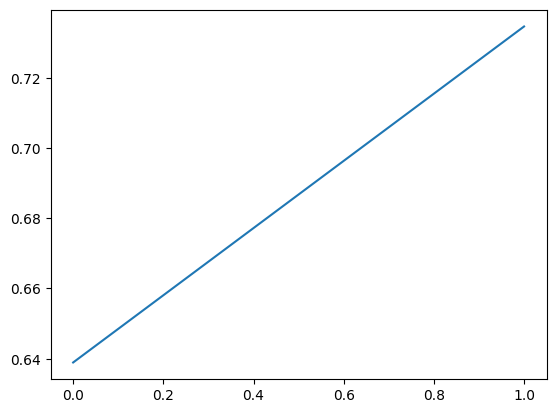

In [44]:
from matplotlib import pyplot as plt
plt.plot(range(len(loss_over_epochs)), loss_over_epochs)

In [14]:
len(lightning_data_module.labeled_loader)

5

In [ ]:
train_loader = lightning_data_module.train_dataloader()
labeled_loader, unlabeled_loader = train_loader["labeled"], train_loader["unlabeled"]
len(labeled_loader)

3295

In [46]:
print(len(lightning_data_module.unlabeled_train_idx))
print(len(lightning_data_module.train_GMM_loader))